# Chapter 5 Case Study

We start off by a detailed look into the word2vec algorithm and examine a python implementation of the skip-gram model with negative sampling. Once the concepts underpinning word2vec are examined, we will use the Gensim package to speed up training time and investigate the translational properties of word embeddings. We will examine Glove embeddings as an alternative to word2vec. Both methods,  however, are unable to handle antonymy, polysemy and word-sense disambiguation. We will study how an embedding methods like sense2vec can better handle these issues. Lastly, we will examing document clustering by using an embeddings approach.

## Software Tools and Libraries

In this case study, we will be examining the inner operations of word2vec's skip-gram & negative sampling approach as well as GloVe embeddings with python. We will also leverage the popular nltk, gensim, glove_python, and spaCy libraries for our analysis. NLTK is a popular open-source toolkit for natural langauge processing and text analytics. The gensim library is an open-source toolkit for vector space modeling and topic modeling implemented in Python with Cython performance acceleration. The glove_python library (https://github.com/maciejkula/glove-python) is an efficient open-source implementation of GloVe in python. SpaCy is a fast open-source NLP library written in Python and Cython for part-of-speech tagging and named entity recognition.

For our analysis, we will leverage the Open American National Corpus (http://www.anc.org/), which consists of roughly 15 million spoken and written words from a variety of sources. Specifically, we will be using the subcorpus which consists of 4531 Slate magazine articles from 1996 to 2000 (approximately 4.2 million words). 


In [ ]:
# Prepping our environment

# Basics
# The glob module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell, although results are returned in arbitrary order. 
# https://docs.python.org/3/library/glob.html
import glob
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.feature_extraction import _stop_words
import math
import re
# string.punctuation is a pre-initialized string used as string constant
# https://www.geeksforgeeks.org/string-punctuation-in-python/
import string

# NLTK
import nltk
# sent_tokenize is a sentence tokenizer
from nltk import tokenize, sent_tokenize

print("Packages imported")

Packages imported


# 1. Exploratory Data Analysis



## 1.1. Get Data

In [ ]:
# Get slate data:  http://www.anc.org/data/oanc/contents/#slate
!wget http://www.anc.org/OANC/OANC_GrAF.tgz --no-check-certificate -O OANC_GrAF.tgz
!tar xf OANC_GrAF.tgz

## original command
# !cd data; tar xf slate1.tgz
# !cd data; tar xf slate2.tgz
# !cd data; tar xf slate3.tgz
# !ls data/slate

!cd OANC-GrAF/data/written_1/journal/slate
!ls OANC-GrAF/data/written_1/journal/slate

--2022-07-03 16:41:26--  http://www.anc.org/OANC/OANC_GrAF.tgz
Resolving www.anc.org (www.anc.org)... 143.229.7.99
Connecting to www.anc.org (www.anc.org)|143.229.7.99|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.anc.org/OANC/OANC_GrAF.tgz [following]
--2022-07-03 16:41:26--  https://www.anc.org/OANC/OANC_GrAF.tgz
Connecting to www.anc.org (www.anc.org)|143.229.7.99|:443... connected.
	requested host name ‘www.anc.org’.
HTTP request sent, awaiting response... 200 OK
Length: 660388635 (630M) [application/x-gzip]
Saving to: ‘OANC_GrAF.tgz’

OANC_GrAF.tgz       100%[===================>] 629.79M  44.3MB/s    in 15s     

2022-07-03 16:41:41 (42.5 MB/s) - ‘OANC_GrAF.tgz’ saved [660388635/660388635]

1   12	15  18	20  23	26  29	31  34	37  4	42  45	48  50	53  6  9
10  13	16  19	21  24	27  3	32  35	38  40	43  46	49  51	54  7
11  14	17  2	22  25	28  30	33  36	39  41	44  47	5   52	55  8


## 1.2. Load Data

Next, we load the slate news articles into a pandas dataframe.

In [ ]:
#Load raw text files

ndf = pd.DataFrame(columns=["filename",'text'])

for datafile in glob.glob( "OANC-GrAF/data/written_1/journal/slate/*/*.txt" ):
    f=open(datafile,"r",encoding="utf-8")
    # pandas.DataFrame.append Append rows of other to the end of caller, returning a new object.
    # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.append.html
    ndf = ndf.append( {'filename':datafile,'text':f.read()} ,ignore_index=True)
    f.close()

ndf.count()

filename    4531
text        4531
dtype: int64

To process the data with word2vec, we must first split each article into separate sentences and create a new dataframe to hold them.

In [ ]:
# Convert into dataframe of sentences

nltk.download('punkt')

df = pd.DataFrame()
# for data in ndf['text'] column
for f in ndf['text']:
  sentence = sent_tokenize(f)
  df = df.append(sentence)
# rename df columns to "text"
df.columns = ['text']

print(df.count())
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


text    214157
dtype: int64


,text
0,\n \n \n \n \n Pos...
1,Clinton.
2,"In addition to the Los\nAngeles Times , the Am..."
3,"Brown, who claims to have solicited ""over a hu..."
4,"Does Wattenberg, who quit the Spectator that s..."


## 1.3. Preprocessing

Word2vec needs clean word tokens for **training**, so lets clean up the sentences by preprocessing to remove punctuation, hidden characters, and uppercase characters.

In [ ]:
def process_text(text):
    
    # re.sub Return the string obtained by replacing the leftmost non-overlapping occurrences of pattern in string by the replacement repl.
    # https://docs.python.org/3/library/re.html#re.sub
    text = re.sub(r"\\n", " ", text)
    text = re.sub(r"\n", " ", text)

    ## Remove puncuation
    # The translate() method returns a string where some specified characters are replaced with the character described in a dictionary, or in a mapping table.
    # https://www.w3schools.com/python/ref_string_translate.asp
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
#    stops = stop_words.ENGLISH_STOP_WORDS
#    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)
    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    ## Stemming
#     text = text.split()
##      The snowballstemmer.stemmer function takes an algorithm name and returns a Stemmer object.
##    https://pypi.org/project/snowballstemmer/
## https://www.geeksforgeeks.org/snowball-stemmer-nlp/
#     stemmer = SnowballStemmer('english')
#     stemmed_words = [stemmer.stem(word) for word in text]
#     text = " ".join(stemmed_words)
    return text

# apply the above function to each record in df['text']
df['text'] = df['text'].map(lambda x: process_text(x))

corpus = df['text'].tolist()
df.head()

,text
0,poster boys david i made paula jones famous br...
1,clinton
2,in addition to the los angeles times the ameri...
3,brown who claims to have solicited over a hund...
4,does wattenberg who quit the spectator that sa...


Let's calculate some basic statistics on this dataset, starting with document length and sentence length.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdba00b5dd0>]],
      dtype=object)

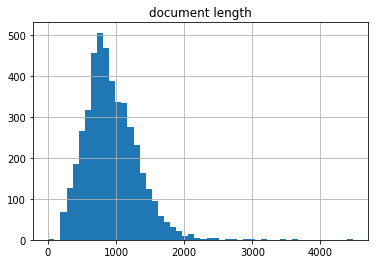

In [ ]:
# document length histogram
# pandas.DataFrame.hist Make a histogram of the DataFrame’s columns.
# bin is the Number of histogram bins to be used.
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html
pd.DataFrame([len(x.split()) for x in ndf['text']],columns= ['document length']).hist(bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdba0a9d750>]],
      dtype=object)

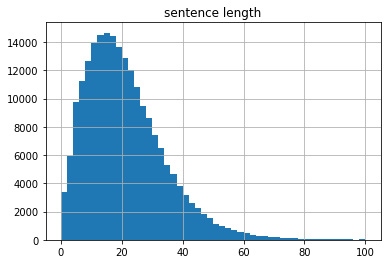

In [ ]:
pd.DataFrame([len(x.split()) for x in df['text']],columns= ['sentence length']).hist(bins=50,range=(0,100))

Let's examine word-frequency by looking at the top 1000 terms in this corpus. The top 100 terms are what we typically consider stop-words, since they are common across most sentences and do not capture much, if any, semantic meaning. As we move further down, we start to see words that play a more important role in conveying the meaning within a sentence or document.

In [ ]:
# nltk.tokenize.word_tokenize Return a tokenized copy of text, using NLTK’s recommended word tokenizer
# https://www.nltk.org/api/nltk.tokenize.html#nltk.tokenize.word_tokenize
words = [tokenize.word_tokenize(x) for x in corpus]
words = [y for x in words for y in x]

# nltk.FreqDist is A frequency distribution for the outcomes of an experiment. A frequency distribution records the number of times each outcome of an experiment has occurred.
# .most_common() List the n most common elements and their counts from the most common to the least.
# https://tedboy.github.io/nlps/generated/generated/nltk.FreqDist.html
word_freq = pd.DataFrame(nltk.FreqDist(words).most_common(1000), columns=['word','frequency'])
print(word_freq)

         word  frequency
0         the     266007
1          of     115973
2           -     114156
3          to     107951
4           a     100993
..        ...        ...
995    sports        498
996        de        498
997  strategy        497
998    argues        496
999    lawyer        496

[1000 rows x 2 columns]


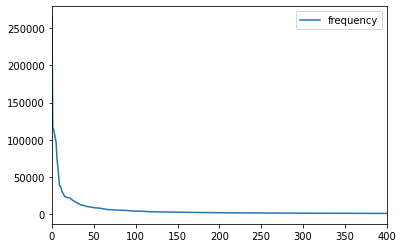

In [ ]:
# pandas.DataFrame.plot Make plots of Series or DataFrame.
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html
word_freq.plot(xlim=(0,400))

# 2.  Learning Word Embeddings

Our goal is to train a set of word embeddings for the corpus above. Let's build a skip-gram model with negative sampling, followed by a GloVe model. Before we train either model, let's see how many unique words exist in the preprocessed 4.86 million word corpus.



## 2.1. Create Dictionary of Vocabulary



In [ ]:
print("len(df):", len(df))
print(df.head())

len(df): 214157
                                                text
0  poster boys david i made paula jones famous br...
1                                           clinton 
2  in addition to the los angeles times the ameri...
3  brown who claims to have solicited over a hund...
4  does wattenberg who quit the spectator that sa...


In [ ]:
# Tokenize and create dictionary

class VocabWord:
    def __init__(self, word):
        self.word = word
        self.count = 0


vocab_items = []
vocab_hash = {}
word_count = 0
        
for token in ['<bol>', '<eol>']:
        vocab_hash[token] = len(vocab_items)
        # append the VocabWord object to vocab_items list
        vocab_items.append(VocabWord(token))

for line in df['text']:
    tokens = line.split()
    for token in tokens:
        if token not in vocab_hash:
            vocab_hash[token] = len(vocab_items)
            vocab_items.append(VocabWord(token))

        ###ORIGINAL comment assert vocab_items[vocab_hash[token]].word == token, 'Wrong vocab_hash index'

        # for the VocabWord[token] object in vocab_items list searched via vocab_hash[token], increase the VocabWord.count +=1
        vocab_items[vocab_hash[token]].count += 1
        word_count += 1

        if word_count % 1000000 == 0:
            print("\rReading word %d" % word_count)

    # Add special tokens <bol> (beginning of line) and <eol> (end of line) by increasing count of them
    vocab_items[vocab_hash['<bol>']].count += 1
    vocab_items[vocab_hash['<eol>']].count += 1
    word_count += 2

print('Total words in training file: %d' % word_count)
print('Vocab size: %d' % len(vocab_items))

Reading word 1000000
Reading word 2000000
Reading word 3000000
Reading word 4000000
Total words in training file: 4860158
Vocab size: 77440


In [ ]:
# # example of vocab_hash and vocab_items
# i = 0
# for k,v in vocab_hash.items():
#   if i < 5:
#     print(k,":", v)
#   i += 1

# print("len(vocab_hash) =", len(vocab_hash))
# print("len(vocab_items) =", len(vocab_items))

# token = "petroleum"
# print("vocab_hash[token] =", vocab_hash[token])
# print("vocab_items[vocab_hash[token]] =", vocab_items[vocab_hash[token]])
# print("vocab_items[vocab_hash[token]].count =", vocab_items[vocab_hash[token]].count)

<bol> : 0
<eol> : 1
poster : 2
boys : 3
david : 4
len(vocab_hash) = 77440
len(vocab_items) = 77440
vocab_hash[token] = 27796
vocab_items[vocab_hash[token]] = <__main__.VocabWord object at 0x7fdb98f82290>
vocab_items[vocab_hash[token]].count = 25


## 2.2. Word2Vec

We are now ready to train the neural network of the word2vec model. Let's define our model parameters:

*  dim = dimension of the word vectors
*  win = context window size (number of tokens)
*  start_alpha = starting learning rate
*  neg = number of samples for negative sampling
*  min_count = minimum number of mentions for a word to be included in vocabulary






In [ ]:
# Initialize parameters of neural network

dim = 100
win = 10
start_alpha = 0.05
neg = 10
min_count = 5

## 2.3. Handling Rare Words

We want to filter out rare words that have few mentions than our min_count threshold. We will be mapping all of these words to a special out-of-vocabulary token. 

In [ ]:
## truncate dictionary and map rare words to <unk> token
truncated = []
truncated.append(VocabWord('<unk>'))
unk_hash = 0

# for rare word tokens, increase counts of <unk> token. For non-rare tokens, add to truncated list
count_unk = 0
for token in vocab_items:
    if token.count < min_count:
        count_unk += 1
        truncated[unk_hash].count += token.count
    else:
        # if VocabWord.count is above min_count add it to the passed list
        truncated.append(token)

truncated.sort(key=lambda token : token.count, reverse=True)

# creating a dictionary for vocab and order 
vocab_hash = {}
for i, token in enumerate(truncated):
    vocab_hash[token.word] = i

# set vocab_items to truncated list
vocab_items = truncated
vocab_size = len(vocab_items)

print('Unknown vocab size:', count_unk)
print('Truncated vocab size: %d' % vocab_size)

# original
# Unknown vocab size: 45842
# Truncated vocab size: 31599

Unknown vocab size: 45842
Truncated vocab size: 31599


In [ ]:
# example of vocab_hash
i = 0
for k, v in vocab_hash.items():
  if i < 5:
    print(f"{k}:{v}")
    i+=1

the:0
<bol>:1
<eol>:2
of:3
-:4


## 2.4. Negative Sampling

To speed up training, let's create a negative sampling lookup table that we will use during training.

In [ ]:
# Create table of probabilities for negative sampling
power = 0.75
norm = sum([math.pow(t.count, power) for t in vocab_items]) # Normalizing constant

table_size = int(1e8) # Length of the unigram table
table = np.zeros(table_size, dtype=int)

p = 0 # Cumulative probability
i = 0
for j, unigram in enumerate(vocab_items):
    p += float(math.pow(unigram.count, power))/norm
    while i < table_size and float(i) / table_size < p:
        table[i] = j
        i += 1

# numpy.random.randint Return random integers from low (inclusive) to high (exclusive)
# https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html
# a function to return a sample from table        
def sample(table,count):
    indices = np.random.randint(low=0, high=len(table), size=count)
    return [table[i] for i in indices]

In [69]:
# example
power = 0.75
norm = sum([math.pow(t.count, power) for t in vocab_items]) # Normalizing constant
table_size = int(1e8) # Length of the unigram table
print("norm:", norm)

p = 0 # Cumulative probability
i = 0
for j, unigram in enumerate(vocab_items[:2]):
    if float(i) / table_size >= p:
      print("j:", j)
      print(f"float({i}) / table_size >= {p},", float(i) / table_size)  
    p += float(math.pow(unigram.count, power))/norm

    print("unigram.count:", unigram.count)
    print("p:", p)

    while i < table_size and float(i) / table_size < p:
 
      i += 1

print(f"table[{1502060}] = {1}")
print("table[1502060]:", table[1502060])

norm: 779781.1936182027
j: 0
float(0) / table_size >= 0, 0.0
unigram.count: 265999
p: 0.015020598793319033
j: 1
float(1502060) / table_size >= 0.015020598793319033, 0.0150206
unigram.count: 214157
p: 0.02778723399736632
table[1502060] = 1
table[1502060]: 1


## 2.5. Training the Model

We are now ready to train the word2vec model. The approach is to train a two-layer (syn0, syn1) neural network by iterating over the sentences in the corpus and adjusting lawyer weights to maximize the probabilities of context words given a target word (skip-gram) with negative sampling. After completion, the weights of the hidden layer syn0 are the word embeddings that we seek.

In [ ]:
# Train skip-gram with negative sampling
import struct

# Sigmoid Function
def sigmoid(z):
    if z > 6:
        return 1.0
    elif z < -6:
        return 0.0
    else:
        # math.exp() Method Return 'E' raised to the power of different numbers
        # https://www.w3schools.com/python/ref_math_exp.asp
        return 1 / (1 + math.exp(-z))

## Initiate syn0 with uniform distribution on the interval [-0.5, 0.5]/dim
# numpy.random.uniform Draw samples from a uniform distribution.
# https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html
# https://en.wikipedia.org/wiki/Continuous_uniform_distribution
tmp = np.random.uniform(low=-0.5/dim, high=0.5/dim, size=(vocab_size, dim))
syn0 = np.ctypeslib.as_ctypes(tmp)
syn0 = np.array(syn0)

tmp = np.zeros(shape=(vocab_size, dim))
# numpy.ctypeslib.as_ctypes Create and return a ctypes object
# https://numpy.org/doc/stable/reference/routines.ctypeslib.html#numpy.ctypeslib.as_ctypes
syn1 = np.ctypeslib.as_ctypes(tmp)
syn1 = np.array(syn1)
    
current_sent = 0
truncated_vocabulary = [x.word for x in vocab_items]
corpus = df['text'].tolist()

while current_sent < df.count()[0]:
    line = corpus[current_sent]
    sent = [vocab_hash[token] if token in truncated_vocabulary else vocab_hash['<unk>'] 
            for token in ['<bol>'] + line.split() + ['<eol>']]

    for sent_pos, token in enumerate(sent):
        # numpy.random.randint Return random integers from low (inclusive) to high (exclusive) of the discrete uniform distribution 
        # https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html
        current_win = np.random.randint(low=1, high=win+1)
        context_start = max(sent_pos - current_win, 0)
        context_end = min(sent_pos + current_win + 1, len(sent))
        context = sent[context_start:sent_pos] + sent[sent_pos+1:context_end]

        for context_word in context:
            embed = np.zeros(dim)
            classifiers = [(token, 1)] + [(target, 0) for target in sample(table, neg)]
            for target, label in classifiers:
                z = np.dot(syn0[context_word], syn1[target])
                p = sigmoid(z)
                g = start_alpha * (label - p)
                embed += g * syn1[target] 
                syn1[target] += g * syn0[context_word] 
            syn0[context_word] += embed

        word_count += 1
    current_sent += 1
    if current_sent % 10000 == 0:
        print("\rReading sentence %d" % current_sent)

# The zip() function takes iterables (can be zero or more), aggregates them in a tuple, and returns it. 
# https://www.programiz.com/python-programming/methods/built-in/zip
embedding = dict(zip(truncated_vocabulary,syn0))
print("Trained embeddings")

# Save embedding

fo = open("word2vec", 'w+')
for token, vector in zip(truncated_vocabulary, syn0):
    fo.write('%s ' % token)
    for s in vector:
        fo.write(('%f '% s))
    fo.write('\n')
fo.close()
print("trained embedding shape")
print(syn0.shape)
print("syn0:", syn0[0][:10])

In [73]:
## skip-gram model walkthrough example pt1
tmp = np.random.uniform(low=-0.5/dim, high=0.5/dim, size=(vocab_size, dim))
syn0 = np.ctypeslib.as_ctypes(tmp)
syn0 = np.array(syn0)
print("syn0\n", syn0[0:4,0:4])

tmp = np.zeros(shape=(vocab_size, dim))
syn1 = np.ctypeslib.as_ctypes(tmp)
syn1 = np.array(syn1)
print("syn1\n", syn1[0:4,0:4])

current_sent = 0
truncated_vocabulary = [x.word for x in vocab_items]
corpus = df['text'].tolist()
print("truncated_vocabulary\n", truncated_vocabulary[0:10])
print("corpus\n", corpus[0])

line = corpus[current_sent]
sent = [vocab_hash[token] if token in truncated_vocabulary else vocab_hash['<unk>'] 
        for token in ['<bol>'] + line.split() + ['<eol>']]
print("line\n", line[0:20])
print("sent\n", sent[0:20]) 

syn0
 [[-2.31925442e-03 -7.40528825e-06 -6.64416266e-04 -1.34546423e-03]
 [ 5.78036291e-04 -2.01705181e-03  3.70576263e-03  1.44298260e-03]
 [-2.11427812e-03 -1.81270882e-03 -1.26721520e-03 -4.93914806e-03]
 [ 1.67565651e-03 -4.10838457e-03  3.13872849e-04 -4.90724791e-03]]
syn1
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
truncated_vocabulary
 ['the', '<bol>', '<eol>', 'of', '-', 'to', 'a', 'and', '<unk>', 'in']
corpus
 poster boys david i made paula jones famous brock who wants everyone to know that he deeply regrets single - handedly bringing down the president is not the only journalist to have reported the allegations of arkansas state troopers who claim to have procured women for then - gov 
line
 poster boys david i 
sent
 [1, 7790, 1655, 362, 19, 135, 1649, 604, 982, 4319, 37, 595, 431, 5, 141, 10, 18, 2138, 8930, 584]


In [75]:
## skip-gram model walkthrough example pt2
stop_send_pos = 1
stop_context = 1
stop_classifier = 1

current_sent = 0

# Sigmoid Function
def sigmoid(z):
    if z > 6:
        return 1.0
    elif z < -6:
        return 0.0
    else:
        # math.exp() Method Return 'E' raised to the power of different numbers
        # https://www.w3schools.com/python/ref_math_exp.asp
        return 1 / (1 + math.exp(-z))

line = corpus[current_sent]
sent = [vocab_hash[token] if token in truncated_vocabulary else vocab_hash['<unk>'] 
        for token in ['<bol>'] + line.split() + ['<eol>']]

for sent_pos, token in enumerate(sent):
  current_win = np.random.randint(low=1, high=win+1)
  context_start = max(sent_pos - current_win, 0)
  context_end = min(sent_pos + current_win + 1, len(sent))
  context = sent[context_start:sent_pos] + sent[sent_pos+1:context_end]
  if sent_pos == stop_send_pos:
    print("sent_pos:", sent_pos )
    print("current_win:", current_win)
    print("context_start:", context_start)
    print("context_end:", context_end)
    print("sent[context_start:sent_pos]:", sent[context_start:sent_pos])
    print("sent[sent_pos+1:context_end]:", sent[sent_pos+1:context_end])
    print("context = sent[context_start:sent_pos] + sent[sent_pos+1:context_end]:", context)

  cnt1 = 0
  for context_word in context:
    embed = np.zeros(dim)
    classifiers = [(token, 1)] + [(target, 0) for target in sample(table, neg)]
    if cnt1 == stop_context and sent_pos == 1:
      print("\ncontext_word:", context_word)   
      print("embed of zeros:", np.zeros(dim)[:3] )
      print("classifiers:", classifiers)  

    cnt2 = 0
    for target, label in classifiers:
      z = np.dot(syn0[context_word], syn1[target])
      p = sigmoid(z)
      g = start_alpha * (label - p)
      if cnt1 == stop_context and cnt2 == stop_classifier and sent_pos == stop_send_pos:
        print("\ntarget:", target )
        print("label:", label)    
        print("syn0[context_word]:\n", syn0[context_word][:3] )
        print("syn1[target]:\n", syn1[target][:3])
        print("z = np.dot(syn0[context_word], syn1[target]):", z )
        print("p = sigmoid(z):", p)
        print("g = start_alpha * (label - p):", g)
        print("\nembed:\n", embed[:3] )

      embed += g * syn1[target] 
      if cnt1 == stop_context and cnt2 == stop_classifier and sent_pos == stop_send_pos:
        print("g * syn1[target]:\n", (g * syn1[target])[:3]) 
        print("embed += g * syn1[target]:\n", embed[:3] )
        print("\nsyn1[target]:\n", syn1[target][:3])

      syn1[target] += g * syn0[context_word]
      if cnt1 == stop_context and cnt2 == stop_classifier and sent_pos == stop_send_pos:
        print("g * syn0[context_word]:\n", (g * syn0[context_word])[:3]  ) 
        print("syn1[target] += g * syn0[context_word]:\n", syn1[target][:3] )
        print("\nsyn0[context_word]:\n", syn0[context_word][:3] )
      cnt2 += 1

    syn0[context_word] += embed
    if cnt1 == stop_context and sent_pos == stop_send_pos: 
      print("embed += g * syn1[target]:\n", embed[:3] )
      print("syn0[context_word] += embed:\n", syn0[context_word][:3])

    cnt1 += 1


IndexError: ignored

The semantic translation properties of these embeddings are noteworthy. Let's examine the cosine similarity between two similar words (man, woman) and two dissimilar words (candy, social). We would expect the similar words to exhibit higher similarity.



In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

print(cosine_similarity([embedding['man']],[embedding['woman']]))
print(cosine_similarity([embedding['candy']],[embedding['social']]))

## before fix
# [[-0.11112623]]
# [[-0.07235765]]

## after fix
# [[0.60299477]]
# [[0.13597429]]

[[0.55100289]]
[[0.17929853]]


## 2.6. Visualize Embedding space

We can visualize the word embeddings using the T-SNE algorithm to map the embeddings to 2D space. Note that T-SNE is a dimensionality reduction technique that preserves notions of proximity within a vector space (points close together in 2D are close in proximity in higher dimensions). The figure below shows the relationships of a 300 word sample from the vocabulary.  

In [72]:
from sklearn.manifold import TSNE
from matplotlib import pylab

words = truncated_vocabulary[200:400]
embeddings = syn0
words_embedded = TSNE(n_components=2).fit_transform(embeddings[200:400])

pylab.figure(figsize=(10, 10))
for i, label in enumerate(words):
  x, y = words_embedded[i, :]
  pylab.scatter(x, y)
  pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                 ha='right', va='bottom')
  
print(i,label)
print(words_embedded[i, :])
pylab.show()

NameError: ignored

## 2.7. Using the Gensim package

The python code above is useful for understanding principles, but is not the fastest to run. The original word2vec package was written in C++ to faciliate rapid training speed over multiple cores. The gensim package provides an API to the word2vec library, as well as several useful methods to examine vectors neighborhoods. Let's see how we can use gensim to train on the sample data corpus.

In [ ]:
# -q for quiet install
!pip install -q gensim -U

import gensim

     |████████████████████████████████| 24.1 MB 66.1 MB/s 


Gensim expects us to provide a set of documents as a list of list of tokens. We will call the simple_preprocess() method of gensim to remove punctuation, special and uppercase characters.

In [ ]:
# pandas.DataFrame.iloc is a Purely integer-location based indexing for selection by position.
# .iloc[] is primarily integer position based (from 0 to length-1 of the axis), but may also be used with a boolean array.
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html
# gensim.utils.simple_preprocess Convert a document into a list of tokens
# https://tedboy.github.io/nlps/generated/generated/gensim.utils.simple_preprocess.html
documents = [gensim.utils.simple_preprocess(df['text'].iloc[i]) for i in range(len(df))]

print(df['text'].iloc[1])
print(documents[1])

clinton 
['clinton']


With the wrapper api provided by the gensim package, training word2vec is as simple as defining a model and passing the set of training documents.

In [ ]:
# gensim.models.word2vec.Word2Vec
# Train, use and evaluate neural networks described in https://code.google.com/p/word2vec/.
# https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec
model = gensim.models.Word2Vec(documents,
                                vector_size=100,
                                window=10,
                                min_count=2,
                                workers=10)
model.train(documents, total_examples=len(documents), epochs=10)

(32581034, 40972460)

## 2.8. Similarity

Let's assess the quality of the learned word embeddings by examining word neighborhoods. If we look at the most similar words to "man" or "book", we find highly similar words in their neighborhoods. So far so good.

In [ ]:
model.wv.most_similar("man",topn=5)

[('guy', 0.6609302163124084),
 ('woman', 0.640536904335022),
 ('person', 0.615658164024353),
 ('soldier', 0.59748774766922),
 ('someone', 0.5713396072387695)]

In [ ]:
model.wv.most_similar("book",topn=5)

[('books', 0.7276024222373962),
 ('novel', 0.6563659906387329),
 ('biography', 0.6214271187782288),
 ('knopf', 0.6049842238426208),
 ('memoir', 0.5842142105102539)]

Let's look at some polysemic words. The similar words to the word "bass" reflect the music definition of bass. That is, they only capture a single word sense (there are no words related to the aquatic definition of bass). Similarly, words similar to "bank" all reflect its financial word sense, but no seashores or riverbeds. This is one of the major shortcomings of word2vec. 

In [ ]:
model.wv.most_similar("bass",topn=5)

[('guitar', 0.7040993571281433),
 ('wails', 0.6594036817550659),
 ('fog', 0.6563571691513062),
 ('fender', 0.6520931124687195),
 ('blazer', 0.6368985176086426)]

In [ ]:
model.wv.most_similar("bank",topn=5)

[('banks', 0.6741498708724976),
 ('bankers', 0.6145675182342529),
 ('imf', 0.595450758934021),
 ('withdrawals', 0.5848575830459595),
 ('loan', 0.574133574962616)]

We can examine the semantic translation properties in more detail with some vector algebra. If we start with the word 'son' and subtract 'man' and add 'woman', we indeed find that 'daughter' is the closest word to the resulting sum. Similarly, if we invert the operation and start with the word 'daughter' and subtract 'woman' and add 'man', we find that 'son' is closest to the sum. Note that reciprocity is not guaranteed with word2vec.

In [ ]:
model.wv.similar_by_vector(model.wv['son']-model.wv['man']+model.wv['woman'],topn=5)

[('daughter', 0.8020919561386108),
 ('sister', 0.7454954981803894),
 ('mother', 0.7408760786056519),
 ('son', 0.7312403917312622),
 ('lover', 0.7233927249908447)]

In [ ]:
model.wv.similar_by_vector(model.wv['daughter']-model.wv['woman']+model.wv['man'],topn=5)

[('son', 0.7732611298561096),
 ('daughter', 0.6890363097190857),
 ('brother', 0.658371090888977),
 ('father', 0.655858039855957),
 ('man', 0.6410151720046997)]

We can also see that word2vec captures geographic similarities by taking the word 'paris', subtracting 'france' and adding 'russia'. There resulting sum is close to what we expect - 'moscow'.

In [ ]:
model.wv.similar_by_vector(model.wv['paris']-model.wv['france']+model.wv['russia'],topn=5)

[('russia', 0.7779466509819031),
 ('ruble', 0.6040285229682922),
 ('chechnya', 0.5884669423103333),
 ('indonesia', 0.5738291144371033),
 ('pakistan', 0.5733829140663147)]

We have previously discussed that word embeddings generated by word2vec are unable to distinguish antonyms, as these words often share the same context words in normal usage and consequentially have learned embeddings close to each other. For instance, the most similar word to 'large' is 'small', or the most similar word to 'hard' is 'easy'. Antonymy is hard! 

In [ ]:
model.wv.most_similar("large",topn=5)

[('small', 0.653571367263794),
 ('enormous', 0.5604685544967651),
 ('huge', 0.5440301895141602),
 ('purchaser', 0.5136063694953918),
 ('size', 0.5092463493347168)]

In [ ]:
model.wv.most_similar("hard",topn=5)

[('easy', 0.6274080276489258),
 ('difficult', 0.5623822212219238),
 ('tempting', 0.5292145609855652),
 ('trying', 0.48897460103034973),
 ('harder', 0.47233259677886963)]

## 2.9. GloVe

Whereas word2vec captures the local context of words within sentences, GloVe embeddings can additionally account for global context across the corpus. Let's take a deeper dive on how to calculate GloVe embeddings. We begin by building a vocabulary dictionary from the corpus.

In [ ]:
# Build vocab

# A Counter is a dict subclass for counting hashable objects. It is a collection where elements are stored as dictionary keys and their counts are stored as dictionary values.
# https://docs.python.org/3/library/collections.html#collections.Counter
from collections import Counter
vocab_count = Counter()

for line in corpus:
    tokens = line.strip().split()
    # update([iterable-or-mapping]) Elements are counted from an iterable or added-in from another mapping (or counter). Like dict.update() but adds counts instead of replacing them. 
    # https://docs.python.org/3/library/collections.html#collections.Counter.update
    vocab_count.update(tokens)

#vocab is a dictionary that stores {word: (index, count frequence of the word)}
vocab = {word: (i, freq) for i, (word, freq) in enumerate(vocab_count.items())}

In [ ]:
# example
vocab_count1 = Counter()

line1 = corpus[0]
print("line1:\n", line1)

tokens1 = line1.strip().split()
print("tokens1:\n", tokens1)

vocab_count1.update(tokens1)
print("vocab_count1:\n", vocab_count1)

print("vocab_count1.items():\n", vocab_count1.items())

vocab1 = {word: (i, freq) for i, (word, freq) in enumerate(vocab_count1.items())}
print("vocab:", vocab1)

line1:
 poster boys david i made paula jones famous brock who wants everyone to know that he deeply regrets single - handedly bringing down the president is not the only journalist to have reported the allegations of arkansas state troopers who claim to have procured women for then - gov 
tokens1:
 ['poster', 'boys', 'david', 'i', 'made', 'paula', 'jones', 'famous', 'brock', 'who', 'wants', 'everyone', 'to', 'know', 'that', 'he', 'deeply', 'regrets', 'single', '-', 'handedly', 'bringing', 'down', 'the', 'president', 'is', 'not', 'the', 'only', 'journalist', 'to', 'have', 'reported', 'the', 'allegations', 'of', 'arkansas', 'state', 'troopers', 'who', 'claim', 'to', 'have', 'procured', 'women', 'for', 'then', '-', 'gov']
vocab_count1:
 Counter({'to': 3, 'the': 3, 'who': 2, '-': 2, 'have': 2, 'poster': 1, 'boys': 1, 'david': 1, 'i': 1, 'made': 1, 'paula': 1, 'jones': 1, 'famous': 1, 'brock': 1, 'wants': 1, 'everyone': 1, 'know': 1, 'that': 1, 'he': 1, 'deeply': 1, 'regrets': 1, 'single': 

## 2.10. Co-occurence matrix

Let's build the word co-occurence matrix from the corpus.  Note that word occurrences go both ways, from the main word to context, and vice versa. For smaller values of the context window, this matrix is expected to be sparse.

In [ ]:
# Build co-occurrence matrix

# scipy.sparse.lil_matrix is a row-based list of lists sparse matrix
# This is a structure for constructing sparse matrices incrementally
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html
from scipy import sparse

min_count = 10
window_size = 5

vocab_size = len(vocab)
# dictionary of index: word
id2word = dict((i, word) for word, (i, _) in vocab.items())

# set up co-occurence matrix
occurrence = sparse.lil_matrix((vocab_size, vocab_size),dtype=np.float64)

for i, line in enumerate(corpus):
    tokens = line.split()
    token_ids = [vocab[word][0] for word in tokens]

    for center_i, center_id in enumerate(token_ids):
        # Collect all word IDs in left window of center word
        context_ids = token_ids[max(0, center_i - window_size) : center_i]
        contexts_len = len(context_ids)

        for left_i, left_id in enumerate(context_ids):
            # Distance from center word
            distance = contexts_len - left_i

            # Weight by inverse of distance between words
            increment = 1.0 / float(distance)

            # Build co-occurrence matrix symmetrically (pretend we
            # are calculating right contexts as well)
            occurrence[center_id, left_id] += increment
            occurrence[left_id, center_id] += increment
    if i % 50000 == 0:
        print("Processing sentence %d" % i)

# Create a generator for efficient calculation
def occur_matrix(vocab, coccurrence, min_count):
  # The zip() function takes iterables (can be zero or more), aggregates them in a tuple, and returns it.
  # https://www.programiz.com/python-programming/methods/built-in/zip
  for i, (row, data) in enumerate(zip(coccurrence.rows, coccurrence.data)):
    # if vocab[word].frequencey < mininum count, do not add to generator
    if min_count is not None and vocab[id2word[i]][1] < min_count:
        continue

    for data_idx, j in enumerate(row):
        # if vocab[word].frequencey < mininum count, do not add to generator
        if min_count is not None and vocab[id2word[j]][1] < min_count:
            continue

        # Yield is a keyword in Python that is used to return from a function without destroying the states of its local variable and when the function is called, the execution starts from the last yield statement. 
        # Any function that contains a yield keyword is termed a generator. Hence, yield is what makes a generator
        # https://www.geeksforgeeks.org/python-yield-keyword/
        yield i, j, data[data_idx]

print("Creating co-occurrence matrix generator")
comatrix = occur_matrix(vocab, occurrence, min_count)

Processing sentence 0
Processing sentence 50000
Processing sentence 100000
Processing sentence 150000
Processing sentence 200000
Creating co-occurrence matrix generator


In [ ]:
# example of Co-occurence matrix
# below shows that the combo of 12,29 hapens twice in the 1st and 3rd doc of the corpus. The total incremental is 2.0
from scipy import sparse

min_count = 10
window_size = 5
vocab_size = len(vocab)
id2word = dict((i, word) for word, (i, _) in vocab.items())

print("vocab:")
i = 0
for k,v in vocab.items():
  if i < 5:
    print(k,v)
  i+=1

print("\nid2word:")
i = 0
for k,v in id2word.items():
  if i < 5:
    print(k,v)
  i+=1 

occurrence_test = sparse.lil_matrix((vocab_size, vocab_size),dtype=np.float64)
print("occurrence_test.shape:", occurrence_test.shape, "\n")

print("example of vocab['poster']:", vocab['poster'], "\n")
context_ids_ex = []

for i, line in enumerate(corpus[:3]):

  print("line:\n", line)
  tokens = line.split()
  token_ids = [vocab[word][0] for word in tokens]
  print("token_ids:\n", token_ids)

  # center_i = 27 # 5, 27
  # center_id = 23 # 5, 23
  for center_i, center_id in enumerate(token_ids):
    # Collect all word IDs in left window of center word
    context_ids = token_ids[max(0, center_i - window_size) : center_i]
    if i == 0 and center_i == 5:
      context_ids_ex = context_ids

    contexts_len = len(context_ids)

    for left_i, left_id in enumerate(context_ids):
        # Distance from center word
        distance = contexts_len - left_i

        # Weight by inverse of distance between words
        increment = 1.0 / float(distance)

        # Build co-occurrence matrix symmetrically (pretend we are calculating right contexts as well)
        print(f"occurrence_test[{center_id}, {left_id}] += {increment}")
        print(f"occurrence_test[{left_id}, {center_id}] += {increment}")      
        occurrence_test[center_id, left_id] += increment
        occurrence_test[left_id, center_id] += increment

print("context_ids example for i==0, center_i==5:\n", context_ids_ex)
print("occurrence_test:\n", occurrence_test)
print("occurrence_test.rows[0]:",occurrence_test.rows[0])
print("occurrence_test.rows[12]:",occurrence_test.rows[12])

In [ ]:
# generator example
# change min_count to show that poster (0, 45) is not added because frequence is lower than min_count
min_count = 50
for i, (row, data) in enumerate(zip(occurrence_test.rows, occurrence_test.data)):
  if min_count is not None and vocab[id2word[i]][1] < min_count:
      continue

  cnt = 0
  for data_idx, j in enumerate(row):
      if min_count is not None and vocab[id2word[j]][1] < min_count:
          continue
      if cnt < 10:
        print(i, j, data[data_idx])
      cnt += 1

i = 23
print("\ni:", i)
print("id2word[i]:", id2word[i])
print("vocab[id2word[i]]:", vocab[id2word[i]])
print("vocab[id2word[i]][1]:", vocab[id2word[i]][1])
print("occurrence_test.rows[i]:", occurrence_test.rows[i])

data_idx = 0
j = 22
print("\ndata_idx:", data_idx)
print("j:", j)
print("vocab[id2word[j]][1]:", vocab[id2word[j]][1])
print("occurrence_test.data[i][data_idx]:", occurrence_test.data[i][data_idx])

22 23 0.2
23 22 0.2
23 23 0.5
23 24 0.3333333333333333
23 25 0.5
23 26 1.0
24 23 0.3333333333333333
25 23 0.5
26 23 1.0

i: 23
id2word[i]: the
vocab[id2word[i]]: (23, 265999)
vocab[id2word[i]][1]: 265999
occurrence_test.rows[i]: [22, 23, 24, 25, 26]

data_idx: 0
j: 22
vocab[id2word[j]][1]: 2571
occurrence_test.data[i][data_idx]: 0.2


## 2.11. GloVe training

We can now train the embeddings by iterating over the documents (sentences) in the corpus.





In [ ]:
# Train Glove Embeddings

from random import shuffle
from math import log
import pickle

iterations = 1 #30 original
dim = 100
learning_rate = 0.05
x_max = 100
alpha = 0.75

vocab_size = len(vocab)
W = (np.random.rand(vocab_size * 2, dim) - 0.5) / float(dim + 1) # weights
print("W:\n", W)
biases = (np.random.rand(vocab_size * 2) - 0.5) / float(dim + 1)

gradient_squared = np.ones((vocab_size * 2, dim), dtype=np.float64)
gradient_squared_biases = np.ones(vocab_size * 2, dtype=np.float64)

data = [
        (
         W[i_main], 
         W[i_context + vocab_size],
         biases[i_main : i_main + 1],
         biases[i_context + vocab_size : i_context + vocab_size + 1],
         gradient_squared[i_main], 
         gradient_squared[i_context + vocab_size],
         gradient_squared_biases[i_main : i_main + 1],
         gradient_squared_biases[i_context + vocab_size: i_context + vocab_size + 1],
         cooccurrence
         )
          for i_main, i_context, cooccurrence in comatrix]

for i in range(iterations):
    global_cost = 0
    # shuffle() Method Shuffle a list (reorganize the order of the list items)
    # https://www.w3schools.com/python/ref_random_shuffle.asp
    shuffle(data)
    for (v_main, v_context, b_main, b_context, gradsq_W_main, gradsq_W_context,
         gradsq_b_main, gradsq_b_context, cooccurrence) in data:

        weight = (cooccurrence / x_max) ** alpha if cooccurrence < x_max else 1

        cost_inner = (
            v_main.dot(v_context) + b_main[0] + b_context[0]- log(cooccurrence)
                      )
        cost = weight * (cost_inner ** 2)
        global_cost += 0.5 * cost

        grad_main = weight * cost_inner * v_context
        grad_context = weight * cost_inner * v_main
        grad_bias_main = weight * cost_inner
        grad_bias_context = weight * cost_inner

        v_main -= (learning_rate * grad_main / np.sqrt(gradsq_W_main))
        v_context -= (learning_rate * grad_context / np.sqrt(gradsq_W_context))

        b_main -= (learning_rate * grad_bias_main / np.sqrt(gradsq_b_main))
        b_context -= (learning_rate * grad_bias_context / np.sqrt(
                gradsq_b_context))

        gradsq_W_main += np.square(grad_main)
        gradsq_W_context += np.square(grad_context)
        gradsq_b_main += grad_bias_main ** 2
        gradsq_b_context += grad_bias_context ** 2
    print('iteration = ',i,' cost = ',global_cost)

# problem with original author codes. W layer is not being updated
print("W:\n", W)
# Save model

with open("glove","wb") as f:
    pickle.dump(W, f, protocol=2)

W:
 [[ 1.96575231e-03 -1.93282022e-03 -3.83058929e-03 ... -3.84097235e-03
   9.93443258e-04  2.22060347e-03]
 [ 2.48875661e-03 -1.11489057e-03 -3.16368063e-03 ... -2.97926372e-03
  -3.67643739e-03 -2.19331296e-03]
 [-2.86017165e-03  1.26390920e-03  2.87232100e-03 ... -4.71086021e-03
  -2.80199015e-03 -4.20589778e-03]
 ...
 [-2.23985155e-03 -4.01860965e-03 -2.59950938e-03 ... -7.80290585e-05
   1.46161288e-03  1.86601729e-03]
 [ 2.27642423e-03 -1.72472717e-03 -1.61545620e-03 ...  8.81360658e-04
  -2.72759756e-03 -1.05047129e-03]
 [-3.63890335e-03 -4.28468171e-03  2.65299962e-03 ...  2.65717839e-03
  -3.62361632e-03 -1.05051810e-03]]
iteration =  0  cost =  0
W:
 [[ 1.96575231e-03 -1.93282022e-03 -3.83058929e-03 ... -3.84097235e-03
   9.93443258e-04  2.22060347e-03]
 [ 2.48875661e-03 -1.11489057e-03 -3.16368063e-03 ... -2.97926372e-03
  -3.67643739e-03 -2.19331296e-03]
 [-2.86017165e-03  1.26390920e-03  2.87232100e-03 ... -4.71086021e-03
  -2.80199015e-03 -4.20589778e-03]
 ...
 [-2.23985

In [ ]:
# Train Glove Embeddings example pt1
vocab_size = len(vocab)
W_test = (np.random.rand(vocab_size * 2, dim) - 0.5) / float(dim + 1) # weights
# print(W_test)
biases = (np.random.rand(vocab_size * 2) - 0.5) / float(dim + 1)
print("W_test.shape:", W_test.shape)
print("biases.shape:", biases.shape)

gradient_squared = np.ones((vocab_size * 2, dim), dtype=np.float64)
gradient_squared_biases = np.ones(vocab_size * 2, dtype=np.float64)
print("W_test.shape:", W_test.shape)
print("biases.shape:", biases.shape)

gen = occur_matrix(vocab, occurrence, min_count)
c = iter(gen)
print("vocab_size:", vocab_size)
i_main, i_context, cooccurrence = next(c)
print("i_main, i_context, cooccurrence:\n", i_main, i_context, cooccurrence)
print("W_test[i_main]:\n", W_test[i_main])
print("W_test[i_context + vocab_size]:\n", W_test[i_context + vocab_size])
print("biases[i_main : i_main + 1]:\n", biases[i_main : i_main + 1])
print("biases[i_context + vocab_size : i_context + vocab_size + 1]:\n", biases[i_context + vocab_size : i_context + vocab_size + 1])
print("gradient_squared[i_main]:\n", gradient_squared[i_main])
print("gradient_squared[i_context + vocab_size]:\n", gradient_squared[i_context + vocab_size])
print("gradient_squared_biases[i_main : i_main + 1]:\n", gradient_squared_biases[i_main : i_main + 1])
print("gradient_squared_biases[i_context + vocab_size: i_context + vocab_size + 1]:\n", gradient_squared_biases[i_context + vocab_size: i_context + vocab_size + 1])
print("cooccurrence:\n", cooccurrence)

W.shape: (154876, 100)
biases.shape: (154876,)
W.shape: (154876, 100)
biases.shape: (154876,)
vocab_size: 77438
i_main, i_context, cooccurrence:
 0 1 1.0
W[i_main]:
 [-2.61304025e-03 -4.72499194e-03  4.22060399e-03  2.29993008e-03
  9.83111266e-04 -3.51698061e-03  2.00642656e-03  1.95923472e-03
  1.91877715e-03 -6.14852995e-05  3.29457199e-04  6.46949425e-04
  6.64991960e-04  2.27420072e-03  4.18798181e-03 -9.58708151e-04
 -2.22951970e-04 -4.27941235e-03 -3.69773851e-03  1.30030375e-04
  3.94777172e-03 -4.62565292e-03 -2.00838145e-03 -3.40219328e-03
  1.21712054e-04 -3.50252554e-03  3.59415099e-03 -4.74737776e-03
 -1.70137927e-03 -4.03600026e-03  3.57662866e-03  4.45752615e-03
 -3.34372435e-03 -2.02822779e-03 -2.38372196e-03 -2.54373335e-03
  3.07839382e-04  1.40159941e-04  4.53875579e-03 -3.50335757e-03
 -3.87199302e-03 -7.15098014e-05  2.84543387e-04 -3.88361682e-03
  1.97393283e-03  2.05263105e-03  1.32918044e-03  2.73094091e-03
 -7.32292636e-04 -4.81063279e-03 -1.79523170e-03 -9.76

In [ ]:
# Train Glove Embeddings example pt2
i = 0
global_cost = 0

shuffle(data)
v_main, v_context, b_main, b_context, gradsq_W_main, gradsq_W_context, gradsq_b_main, gradsq_b_context, cooccurrence = data[0]

weight = (cooccurrence / x_max) ** alpha if cooccurrence < x_max else 1
print("weight = (cooccurrence / x_max) ** alpha if cooccurrence < x_max else 1:\n", weight)

cost_inner = (v_main.dot(v_context) + b_main[0] + b_context[0]- log(cooccurrence))
print("cost_inner:\n", cost_inner)
cost = weight * (cost_inner ** 2)
print("cost:\n", cost)

print("global_cost before:", global_cost)
global_cost += 0.5 * cost
print("global_cost after:", global_cost)

grad_main = weight * cost_inner * v_context
grad_context = weight * cost_inner * v_main
grad_bias_main = weight * cost_inner
grad_bias_context = weight * cost_inner
print("grad_main:\n", grad_main)
print("grad_context:\n", grad_context)
print("grad_bias_main:\n", grad_bias_main)
print("grad_bias_context:\n", grad_bias_context)

print("v_main before:\n", v_main)
print("v_context before:\n", v_context)
v_main -= (learning_rate * grad_main / np.sqrt(gradsq_W_main))
v_context -= (learning_rate * grad_context / np.sqrt(gradsq_W_context))
print("v_main after:\n", v_main)
print("v_context after:\n", v_context)

print("b_main before:\n", b_main)
print("b_context before:\n", b_context)
b_main -= (learning_rate * grad_bias_main / np.sqrt(gradsq_b_main))
b_context -= (learning_rate * grad_bias_context / np.sqrt(gradsq_b_context))
print("b_main after:\n", b_main)
print("b_context after:\n", b_context)

print("gradsq_W_main before:\n", gradsq_W_main)
print("gradsq_W_context before:\n", gradsq_W_context)
print("gradsq_b_main before:\n", gradsq_b_main)
print("gradsq_b_context before:\n", gradsq_b_context)
gradsq_W_main += np.square(grad_main)
gradsq_W_context += np.square(grad_context)
gradsq_b_main += grad_bias_main ** 2
gradsq_b_context += grad_bias_context ** 2
print("gradsq_W_main after:\n", gradsq_W_main)
print("gradsq_W_context after:\n", gradsq_W_context)
print("gradsq_b_main after:\n", gradsq_b_main)
print("gradsq_b_context after:\n", gradsq_b_context)

print('iteration = ',i,' cost = ',global_cost)

weight = (cooccurrence / x_max) ** alpha if cooccurrence < x_max else 1:
 0.03162277660168379
cost_inner:
 0.11496723857845219
cost:
 0.0004179729728619392
global_cost before: 0
global_cost after: 0.0002089864864309696
grad_main:
 [-1.22520440e-04 -9.64879477e-05  3.32252723e-05 -4.21085008e-05
  7.81920509e-05  3.97177280e-05 -1.59709448e-04 -6.39804357e-05
 -1.60708439e-04  2.01668008e-04 -6.00268295e-05  1.44128380e-04
  5.81030894e-05  5.02717225e-05  1.34998829e-04  6.82616245e-05
  1.83624021e-04  1.38874519e-05  1.31656909e-04 -3.42919345e-05
  3.06662021e-05 -1.46376678e-05  2.00110523e-04 -1.06829190e-04
  1.06933319e-04  3.06408034e-05 -1.56477989e-05  7.90706070e-06
 -1.23926395e-04 -1.22086304e-04 -8.57060684e-05  5.57271390e-05
 -6.86738663e-05  6.40321932e-05 -4.53767651e-05 -1.61764427e-04
 -1.98766128e-05  6.01221150e-05  1.01318062e-04  5.62001620e-06
  2.37121809e-04 -4.07991239e-06  1.08828330e-04 -1.56199062e-04
 -8.13470156e-05 -6.90738311e-05  1.22345080e-04  1.10

The learned weight matrix consists of two sets of vectors, one if the word is in the main word position and one for the context word position. We will average them to generate the final GloVe embeddings for each word.

In [ ]:
# Merge main and context word vectors by taking average

def merge_vectors(W, merge_fun=lambda m, c: np.mean([m, c], axis=0)):

    vocab_size = int(len(W) / 2)
    for i, row in enumerate(W[:vocab_size]):
        # for row and W[i + vocab_size] in W, apply the mean of the the two array with the defined lambda in the function parameter
        merged = merge_fun(row, W[i + vocab_size])
        # numpy.linalg.norm This function is able to return one of eight different matrix norms, or one of an infinite number of vector norms
        
        # https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html
        merged /= np.linalg.norm(merged)
        W[i, :] = merged

    return W[:vocab_size]

embedding = merge_vectors(W)
len(embedding)

77438

In [ ]:
# example
def merge_vectors_test(W_test, merge_fun=lambda m, c: np.mean([m, c], axis=0)):

    vocab_size = 1
    for i, row in enumerate(W_test[:vocab_size]):
        print(f"W_test[i, :] = W_test[{i}, :]")
        print(f"W_test[i + vocab_size, :] = W_test[{i + vocab_size}, :]")
        print("row:\n", row)
        print("W_test[i + vocab_size]:\n", W_test[i + vocab_size])
        merged = merge_fun(row, W_test[i + vocab_size])
        print("merged:\n", merged)
        # numpy.linalg.norm This function is able to return one of eight different matrix norms, or one of an infinite number of vector norms      
        # https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html
        merged /= np.linalg.norm(merged)
        print("merged /= np.linalg.norm(merged):\n", merged)
        W_test[i, :] = merged

    return W_test[:vocab_size]

embedding = merge_vectors_test(W_test)

W[i, :] = W[0, :]
W[i + vocab_size, :] = W[1, :]
row:
 [-5.68514547e-03  3.78121475e-02  1.50433615e-01 -6.85655647e-02
 -5.45456268e-02  1.42981154e-02 -1.98495952e-01  7.58662146e-03
  4.35027938e-02 -8.89984137e-02 -8.12344880e-02 -1.56733843e-02
 -1.42235306e-01 -7.43664589e-02 -7.88582646e-02  1.34162233e-02
  4.93715937e-02  1.18701284e-01 -2.44143362e-02 -5.97511202e-02
 -1.38845957e-02 -1.41490479e-01  2.05158407e-03  5.80645024e-02
 -2.11832876e-01 -1.03169187e-02 -1.05237987e-01  2.19850753e-01
 -7.48859856e-02  2.19400431e-02  7.25113057e-02 -1.77594560e-01
  2.05287276e-02 -4.15249354e-02  5.02243971e-03 -3.85334714e-02
  6.58326686e-02 -1.65558779e-03  2.01459266e-03  7.70130675e-02
  5.14273644e-02 -1.50712462e-01 -1.35017094e-01  1.02615245e-01
  9.89200473e-02 -7.96183567e-02  5.90637349e-02 -9.40753486e-02
 -6.28403527e-02  2.02828427e-01  2.04892101e-02  4.44524210e-03
 -1.01022531e-01  8.27063411e-02 -1.67494198e-01 -1.15225517e-01
  1.14398446e-01  1.68014051e-01  1

##2.12. GloVe Vector Similarity

Let's examine the translational properties of these vectors. We define a simple function that returns the 5 most similar words to the word "man".

In [ ]:
# Find most similar words

def most_similar(W, vocab, id2word, word, n=5):
    """
    Find the `n` words most similar to the given `word`. The provided
    `W` must have unit vector rows, and must have merged main- and
    context-word vectors (i.e., `len(W) == len(word2id)`).
    Returns a list of word strings.
    """

    # The assert keyword lets you test if a condition in your code returns True, if not, the program will raise an AssertionError.
    # https://www.w3schools.com/python/ref_keyword_assert.asp
    assert len(W) == len(vocab)

    word_id = vocab[word][0]

    dists = np.dot(W, W[word_id])
    # numpy.argsort Returns the indices that would sort an array.
    # https://numpy.org/doc/stable/reference/generated/numpy.argsort.html
    # [::-1] reverse the order of the array
    top_ids = np.argsort(dists)[::-1][:n + 1]

    return [(id2word[id],dists[id]) for id in top_ids if id != word_id][:n]

for term in most_similar(embedding, vocab, id2word, 'man', 5): print(term)

np.argsort(dists): [19376 46409 45355 ...  2503 49652   110]
np.argsort(dists)[::-1]: [  110 49652  2503 ... 45355 46409 19376]
('bolder', 0.4245263680906412)
('sued', 0.38431142482560765)
('screenwriters', 0.3815589288756248)
('seinfeld', 0.3764716722392254)
('dardennes', 0.3747073389860485)


Interestingly, the similarirty results fall into two categories. Whereas "woman" and "girl" have similar semantic meaning to 'man', the words "dead" and "young" do not. But these words do co-occur often, with phrases such as "young man" or "dead man". GloVe embeddings can capture both contexts. We can see this when we visualize the embeddings using T-SNE.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


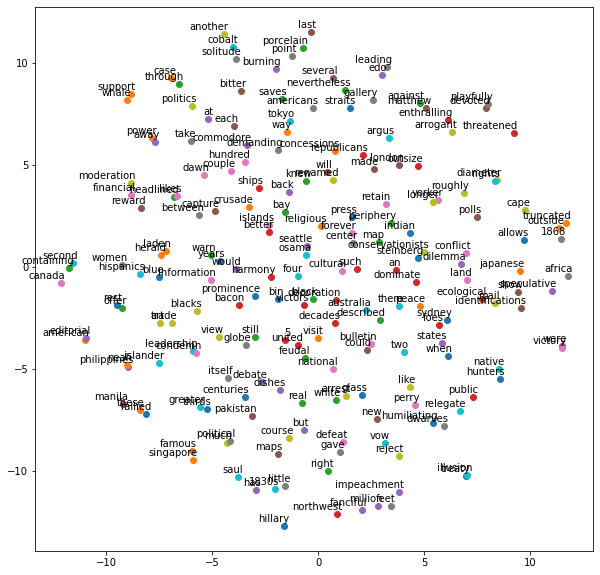

In [ ]:
from sklearn.manifold import TSNE
from matplotlib import pylab

words = list(vocab.keys())[200:400]
# TSNE returns an array of coordinates
words_embedded = TSNE(n_components=2).fit_transform(embedding[200:400])

pylab.figure(figsize=(10, 10))
# for each word in list, plot its corresponding coordinates from words_embedded
for i, label in enumerate(words):
  x, y = words_embedded[i, :]
  pylab.scatter(x, y)
  pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                 ha='right', va='bottom')
pylab.show()

## 2.13. Using the Glove Package

While useful, our python implemention is too slow to run with a large corpus. The 'glove' and 'glove_python' libraries are python packages that implement the GloVe algoritm efficiently. Let's retrain our embeddings using the 'glove_python' package.

In [ ]:
# GloVe original project
# https://nlp.stanford.edu/projects/glove/
!pip install glove-python-binary

# https://github.com/maciejkula/glove-python
from glove import Corpus, Glove

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To do so, we begin by defining a corpus of documents. 

In [ ]:
# Corpus() is a Class for constructing a cooccurrence matrix from a corpus.

# https://github.com/maciejkula/glove-python/blob/master/glove/corpus.py
corpus = Corpus()

corpus.fit(documents, window=5)

We then learn embeddings from this corpus.

In [ ]:
# https://github.com/maciejkula/glove-python
glove = Glove(no_components=100, learning_rate=0.05)

e =  5 #30 original
glove.fit(corpus.matrix, epochs=e, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)

Performing 5 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4


Let's asses the quality of these embeddings by examining a few words.

In [ ]:
glove.most_similar('man',number=6)

[('woman', 0.9964162327847419),
 ('person', 0.971758517748654),
 ('shot', 0.9691691219101062),
 ('named', 0.9681275269815055),
 ('trouble', 0.967755765916375)]

In [ ]:
glove.most_similar('nice',number=6)

[('enough', 0.978109239998327),
 ('considered', 0.977890457537049),
 ('useful', 0.9754780390205541),
 ('reasonable', 0.9749492497057027),
 ('quickly', 0.9738514861161022)]

In [ ]:
glove.most_similar('apple',number=6)

[('program', 0.9869222145395969),
 ('audience', 0.9863049972491609),
 ('industry', 0.9853405642532247),
 ('agreement', 0.9824786904069224),
 ('firm', 0.9824655651012044)]

Once again, the most similar words exhibit both semantic similarity as well as high co-occurrence probability. Even with the additional context, GloVe embeddings still lack the ability to handle antonyms and word sense disambiguation. 

# 3. Document Clustering

The use of word embeddings provides a useful and efficient means for document clustering in comparison to traditional approaches such as LSA or LDA. The simplest approach is a bag-of-words method where a document vector is created by averaging the vectors of each of the words in the document. Let's take our Slate corpus and see what we can find with this approach.



##3.1. Document vectors

We create a set of document vectors by adding the vectors of each word in the document and dividing by the total number of words.

In [ ]:
documents = [gensim.utils.simple_preprocess(ndf['text'].iloc[i]) for i in range(len(ndf))]

corpus = Corpus()
corpus.fit(documents, window=5)

glove = Glove(no_components=100, learning_rate=0.05)
glove.fit(corpus.matrix, epochs=10, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)
print("Glove embeddings trained.")

doc_vectors = []
for doc in documents:
    vec = np.zeros(glove.word_vectors[glove.dictionary['the']].shape)
    for token in doc:
      vec += glove.word_vectors[glove.dictionary[token]]
    # if current doc's length > 0, then divide vec matrix by len(doc)
    if len(doc) > 0:
      vec = vec/len(doc)
    doc_vectors.append(vec)
    
print("Processed documents = ",len(doc_vectors))

Performing 10 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Glove embeddings trained.
Processed documents =  4531


In [ ]:
# example
print("ndf['text'].iloc[0][:100].strip():\n", ndf['text'].iloc[0][:100].strip() )
print("\ndocuments[0]:\n", documents[0])

doc_vectors = []
doc = documents[0]

vec = np.zeros(glove.word_vectors[glove.dictionary['the']].shape)
print("\nglove.word_vectors[glove.dictionary['the']].shape:", glove.word_vectors[glove.dictionary['the']].shape)
print("vec:\n",vec)

i = 0
for token in doc:
  vec += glove.word_vectors[glove.dictionary[token]]
  if i == 0:
    print("token:", token)
    print("glove.dictionary[token]:", glove.dictionary[token])
    print("vec += glove.word_vectors[glove.dictionary[token]]:\n", glove.word_vectors[glove.dictionary[token]])
  i += 1

if len(doc) > 0:
  vec = vec/len(doc)
doc_vectors.append(vec)

ndf['text'].iloc[0][:100].strip():
 Poster Boys

            David "I Made Paula Jones Famous" Bro

documents[0]:
 ['poster', 'boys', 'david', 'made', 'paula', 'jones', 'famous', 'brock', 'who', 'wants', 'everyone', 'to', 'know', 'that', 'he', 'deeply', 'regrets', 'single', 'handedly', 'bringing', 'down', 'the', 'president', 'isn', 'the', 'only', 'journalist', 'to', 'have', 'reported', 'the', 'allegations', 'of', 'arkansas', 'state', 'troopers', 'who', 'claim', 'to', 'have', 'procured', 'women', 'for', 'then', 'gov', 'clinton', 'in', 'addition', 'to', 'the', 'los', 'angeles', 'times', 'the', 'american', 'spectator', 'in', 'april', 'printed', 'long', 'well', 'documented', 'piece', 'by', 'daniel', 'wattenberg', 'recounting', 'the', 'tale', 'of', 'trooper', 'brown', 'who', 'claims', 'to', 'have', 'solicited', 'over', 'hundred', 'women', 'for', 'clinton', 'does', 'wattenberg', 'who', 'quit', 'the', 'spectator', 'that', 'same', 'year', 'still', 'stand', 'by', 'his', 'story', 'yes', 'do', 'h

## 3.2. Cluster Analysis

Let's visualize these embeddings and see if we can spot any clusters.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


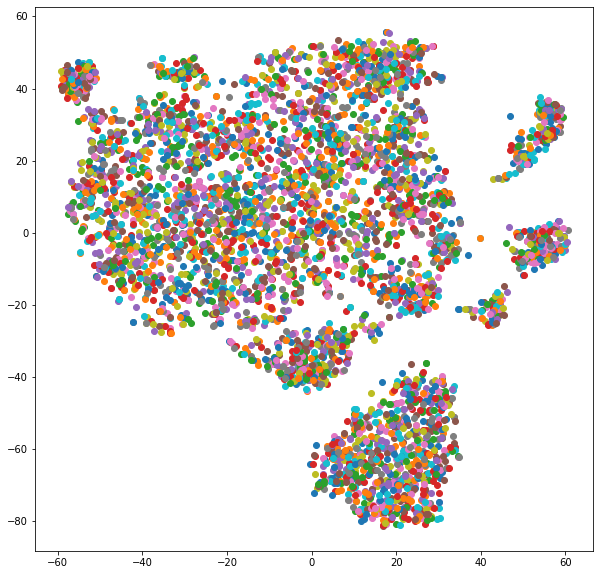

In [ ]:
from sklearn.manifold import TSNE
from matplotlib import pylab

docs_embedded = TSNE(n_components=2).fit_transform(doc_vectors)

pylab.figure(figsize=(10, 10))
for i, label in enumerate(docs_embedded):
  x, y = docs_embedded[i, :]
  pylab.scatter(x, y)
pylab.show()

# 4. Word Sense Disambiguation

Word sense disambiguation is an important task in computational linguistics. However, word2vec or GloVe embeddings map words to a single embedding vector, and therefore lack the ability to disambiguate between multiple senses of words. The sense2vec algorithm is an improved approach that can deal with polysemy or antonymy through supervised disambiguation. Moreover, sense2vec is computationally inexpensive and can be implemented as a preprocessing task prior to training a word2vec or GloVe model. To see this, let's apply the sense2vec algoritm to our corpus by leveraging the spaCy library to generate part-of-speech labels that will serve as our supervised disambiguation labels.


## 4.1. Load spaCy

In [ ]:
# spaCy is a free, open-source library for advanced Natural Language Processing (NLP) in Python.
# https://spacy.io/usage/spacy-101
!pip install spacy
# en_core_web_sm is an English pipeline optimized for CPU
!python -m spacy download en_core_web_sm

import spacy
# spacy.load Load a pipeline using the name of an installed package, a string path or a Path-like object
# https://spacy.io/api/top-level
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

print('Model loaded')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 5.2 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Model loaded


## 4.2. Supervised Disambiguation Annotations

Let's process the sentences in our corpus using the spaCy NLP annotations.

In [ ]:
corpus = df['text'].tolist()
print("Number of docs = ",len(corpus))

docs = []
count = 0
for item in corpus:
  docs.append(nlp(item))
  count += 1
  if count % 100000 == 0:
    print("Processed document #",count)

Number of docs =  214157
Processed document # 100000
Processed document # 200000


In [ ]:
print("docs[0]:\n", docs[0])
print("type(docs[0]):", type(docs[0]))
print("docs[0][0].text:", docs[0][0].text)
print("docs[0][0].pos_:", docs[0][0].pos_)

docs[0]:
 poster boys david i made paula jones famous brock who wants everyone to know that he deeply regrets single - handedly bringing down the president is not the only journalist to have reported the allegations of arkansas state troopers who claim to have procured women for then - gov 
type(docs[0]): <class 'spacy.tokens.doc.Doc'>
docs[0][0].text: poster
docs[0][0].pos_: NOUN


## 4.3. POS Label Annotation

We will create a separate corpus where each word is augmented by its part-of-speech label. For instance, the word 'he' is mapped to 'he_PRON'.

In [ ]:
sense_corpus = [[x.text+"_"+x.pos_ for x in y] for y in docs]
print(corpus[0])
print(' '.join(sense_corpus[0]))

poster boys david i made paula jones famous brock who wants everyone to know that he deeply regrets single - handedly bringing down the president is not the only journalist to have reported the allegations of arkansas state troopers who claim to have procured women for then - gov 
poster_NOUN boys_NOUN david_PROPN i_PRON made_VERB paula_PROPN jones_PROPN famous_ADJ brock_NOUN who_PRON wants_VERB everyone_PRON to_PART know_VERB that_SCONJ he_PRON deeply_ADV regrets_VERB single_ADV -_PUNCT handedly_ADV bringing_VERB down_ADP the_DET president_NOUN is_AUX not_PART the_DET only_ADJ journalist_NOUN to_PART have_AUX reported_VERB the_DET allegations_NOUN of_ADP arkansas_PROPN state_NOUN troopers_NOUN who_PRON claim_VERB to_PART have_AUX procured_VERB women_NOUN for_ADP then_ADV -_PUNCT gov_NOUN


## 4.4. Train using word2vec

With the new preprocessed corpus, we can proceed with training word2vec.

In [ ]:
model = gensim.models.Word2Vec(sense_corpus,
                                vector_size=100,
                                window=10,
                                min_count=2,
                                workers=10)
model.train(sense_corpus, total_examples=len(sense_corpus), epochs=10)

(34864557, 44597750)

## 4.5. Evaluate Word Sense Disambiguation

We can use this trained model to look at how words like 'run' or 'lie' can be disambiguated based on their part-of-speech.

In [ ]:
model.wv.most_similar("run_NOUN",topn=5)

[('haul_NOUN', 0.6470648646354675),
 ('sosa_NOUN', 0.5888848900794983),
 ('runs_NOUN', 0.5395485162734985),
 ('season_NOUN', 0.5328521132469177),
 ('term_NOUN', 0.49924203753471375)]

In [ ]:
model.wv.most_similar("run_VERB",topn=5)

[('hold_VERB', 0.6070622205734253),
 ('break_VERB', 0.6056172251701355),
 ('running_VERB', 0.5910267233848572),
 ('compete_VERB', 0.5910205841064453),
 ('put_VERB', 0.5894866585731506)]

In [ ]:
model.wv.most_similar("lie_NOUN",topn=5)

[('truth_NOUN', 0.6045648455619812),
 ('perjury_NOUN', 0.5507210493087769),
 ('damnable_ADJ', 0.5381466746330261),
 ('sin_NOUN', 0.5278658270835876),
 ('liar_NOUN', 0.5273505449295044)]

In [ ]:
model.wv.most_similar("lie_VERB",topn=5)

[('talk_VERB', 0.6831597685813904),
 ('expose_VERB', 0.6429332494735718),
 ('testify_VERB', 0.6356839537620544),
 ('dispatch_VERB', 0.5610036849975586),
 ('sleep_VERB', 0.551236093044281)]